In [1]:
DATA_FILE ='../data/transportation-railroad-casualties.csv'

In [2]:
####################################################
# Boilerplate import/setup code for general analysis
####################################################

import datetime as dt
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

# Useful colors to reference
SNS_BLUE, SNS_GREEN, SNS_RED, SNS_PURPLE, SNS_YELLOW, SNS_CYAN = sns.color_palette()
# sns.set_palette(sns.color_palette("cubehelix", 8))
pd.set_option('display.max_columns', 500)
plt.rcParams.update({
  'font.size': 14,
  'axes.titlesize': 'x-large',
  'axes.labelsize': 'large',
  'xtick.labelsize': 'medium',
  'ytick.labelsize': 'medium',
  'legend.fancybox': True,
  'legend.fontsize': 'medium',
  'legend.frameon': True,
  'legend.framealpha': 0.7,
  'figure.figsize': ['9', '6'],
})

####################################################
# everett@bayesimpact.org
####################################################

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
# Helpers (currently cut and paste around different notebooks... oops)

def percentify_axis(ax, which):
    which = which.lower()
    if which in ('x', 'both'):
        ax.set_xticklabels(['%.0f%%' % (t*100) for t in ax.get_xticks()])
    if which in ('y', 'both'):
        ax.set_yticklabels(['%.0f%%' % (t*100) for t in ax.get_yticks()])

color_idx = 0
CYCLE_COLORS = sns.color_palette()
def next_color():
    global color_idx
    c = CYCLE_COLORS[color_idx] 
    color_idx = (color_idx + 1) % len(CYCLE_COLORS)
    return c

def count_unique(s):
    values = s.unique()
    return sum(1 for v in values if pd.notnull(v))

def missing_pct(s):
    missing = N - s.count()
    return missing * 100.0 / N

def complete_pct(s):
    return 100 - missing_pct(s)

def summarize_completeness_uniqueness(df):
    print '*** How complete is each feature? How many different values does it have? ***'
    rows = []
    for col in df.columns:
        rows.append([col, '%.0f%%' % complete_pct(df[col]), count_unique(df[col])])
    return pd.DataFrame(rows, columns=['Column Name', 'Complete (%)','Unique Values'])

def summarize_completeness_over_time(df, time_col, transpose=True):
    print '*** Data completeness over time per column ***'
    x = df.groupby(time_col).count()
    x = x.div(df.groupby(time_col).size(), axis=0)
    for col in x.columns:
        x[col] = x[col].apply(lambda value: '%.0f%%' % (value * 100))
    if transpose:
        return x.T
    return x

def plot_top_hist(df, col, top_n=10, skip_below=.01):
    '''Plot a histogram of a categorical dataframe column, limiting to the most popular.'''
    counts = df[col].value_counts(True, ascending=True)
    missing = missing_pct(df[col])
    if counts.max() < (skip_below / (1 - missing)):
        print 'Skipping "%s" histogram -- most common value is < %.0f%% of all cases' % (col, skip_below*100)
        return
    fig, ax = plt.subplots(1)
    explanation = ''
    if len(counts) > top_n:
        explanation = ' (top %d of %d)' % (top_n, len(counts))
        counts = counts.iloc[-top_n:]
    explanation += ' -- %.0f%% missing' % (missing)
    counts.plot(kind='barh', ax=ax, color=next_color())
    ax.set_title('Rows by "%s"%s' % (col, explanation))
    ax.set_xticklabels(['%.0f%%' % (t*100) for t in ax.get_xticks()])


In [4]:
df = pd.read_csv(DATA_FILE)
print '%d rows %d columns' % df.shape
N = len(df)
df.head()

1067153 rows 38 columns


/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (9,10,11,20,22,23,24,25,26,28,30,31,32,33,34,37) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,YEAR,MONTH,DAY,TIME24HR,TIMEMIN,SUICIDE_ATTEMPTED,RAILROAD,INCIDENT_NUM,TYPPERS,JOBCODE,INJURY_NATURE,LOCATION,IFATAL,AGE,DAYSABS,DAYSRES,STATE,TYPRR,REGION,FATAL,COUNTY,CNTYCD,STCNTY,ALCOHOL,DRUG,PHYACT,LOCA,LOCB,LOCC,EVENT,TOOLS,INJCAUS,HZMEXPOS,TERMINAT,COVERDATA,LATITUDE,LONGITUDE,NARRATIVE
0,1975,12,NaN,NaN,NaN,NaN,YN,1275001,A,615,20,3,NaN,60,9,0,39,2,2,False,NaN,NaN,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1975,12,NaN,NaN,NaN,NaN,WSR,0012,A,313,91,NaN,NaN,34,0,0,5,2,5,False,NaN,NaN,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1975,12,NaN,NaN,NaN,NaN,WP,2123575,D,NaN,10,5,NaN,0,0,0,6,2,7,False,NaN,NaN,NaN,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1975,12,NaN,NaN,NaN,NaN,WP,2123375,E,NaN,30,5,NaN,57,0,0,6,2,7,False,NaN,NaN,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1975,12,NaN,NaN,NaN,NaN,WP,2122075,E,NaN,70,3,NaN,11,0,0,6,2,7,False,NaN,NaN,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
summarize_completeness_uniqueness(df)

*** How complete is each feature? How many different values does it have? ***


,Column Name,Complete (%),Unique Values
0,YEAR,100%,41
1,MONTH,100%,12
2,DAY,19%,32
3,TIME24HR,19%,24
4,TIMEMIN,19%,60
5,SUICIDE_ATTEMPTED,5%,2
6,RAILROAD,100%,1181
7,INCIDENT_NUM,100%,735516
8,TYPPERS,100%,10
9,JOBCODE,81%,243


In [6]:
summarize_completeness_over_time(df, 'YEAR', transpose=False)

*** Data completeness over time per column ***


,MONTH,DAY,TIME24HR,TIMEMIN,SUICIDE_ATTEMPTED,RAILROAD,INCIDENT_NUM,TYPPERS,JOBCODE,INJURY_NATURE,LOCATION,IFATAL,AGE,DAYSABS,DAYSRES,STATE,TYPRR,REGION,FATAL,COUNTY,CNTYCD,STCNTY,ALCOHOL,DRUG,PHYACT,LOCA,LOCB,LOCC,EVENT,TOOLS,INJCAUS,HZMEXPOS,TERMINAT,COVERDATA,LATITUDE,LONGITUDE,NARRATIVE
YEAR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1975,100%,0%,0%,0%,0%,100%,100%,100%,86%,100%,99%,12%,100%,100%,100%,100%,100%,100%,100%,0%,0%,0%,100%,100%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%
1976,100%,0%,0%,0%,0%,100%,100%,100%,87%,100%,98%,12%,100%,100%,100%,100%,100%,100%,100%,0%,0%,0%,100%,100%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%
1977,100%,0%,0%,0%,0%,100%,100%,100%,89%,100%,100%,12%,98%,100%,100%,100%,100%,100%,100%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%
1978,100%,0%,0%,0%,0%,100%,100%,100%,89%,100%,100%,12%,97%,100%,100%,100%,100%,100%,100%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%
1979,100%,0%,0%,0%,0%,100%,100%,100%,90%,100%,99%,12%,98%,100%,100%,100%,100%,100%,100%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%
1980,100%,0%,0%,0%,0%,100%,100%,100%,90%,100%,99%,12%,98%,100%,100%,100%,100%,100%,100%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%
1981,100%,0%,0%,0%,0%,100%,100%,100%,89%,100%,99%,12%,98%,100%,100%,100%,100%,100%,100%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%
1982,100%,0%,0%,0%,0%,100%,100%,100%,88%,100%,98%,67%,98%,100%,100%,100%,100%,100%,100%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%
1983,100%,0%,0%,0%,0%,100%,100%,100%,86%,100%,98%,80%,97%,100%,100%,100%,100%,100%,100%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%


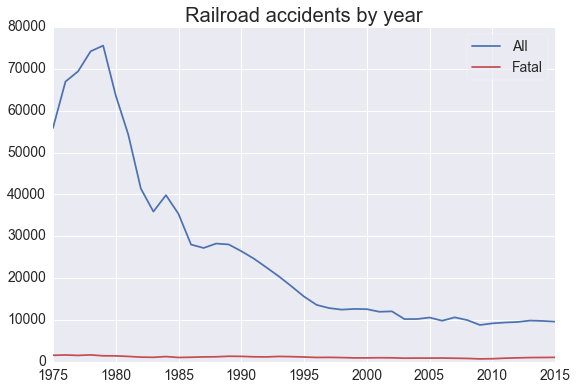

In [7]:
fig, ax = plt.subplots(1)
df['YEAR'].value_counts().sort_index().plot(ax=ax, label='All')
df[df['FATAL']]['YEAR'].value_counts().sort_index().plot(ax=ax, label='Fatal', COLOR=SNS_RED)
ax.legend()
ax.set_title('Railroad accidents by year')

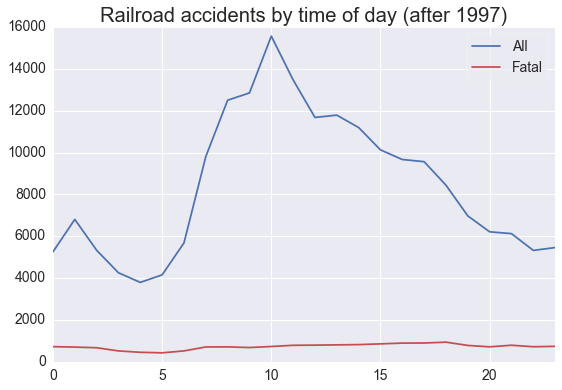

In [10]:
fig, ax = plt.subplots(1)
df['TIME24HR'].value_counts().sort_index().plot(ax=ax, label='All')
df[df['FATAL']]['TIME24HR'].value_counts().sort_index().plot(ax=ax, label='Fatal', COLOR=SNS_RED)
ax.legend()
ax.set_title('Railroad accidents by hour of day (1997+)')
ax.set_xlabl()

### Summarize ALL the things!

In [ ]:
for col in df.columns:
    plot_top_hist(df, col)